### DCSBM
Runs the DCSBM model on the 4 small synthetic datasets and shows their performance


In [1]:
import os
import numpy as np
import pandas as pd
from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
from graspologic.models import DCSBMEstimator
%matplotlib inline

os.chdir("../..")
print(os.getcwd())  # /Users/tonpoppe/workspace

from tigger_package.metrics.distribution_metrics import compare_metrics, compare_metrics2

/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


In [2]:
config_dict = {
    'base_path': "data/enron/",
    'nodes_path': "enron_nodes.parquet",
    'edges_path': "enron_edges.parquet",
}

In [3]:
edges = pd.read_parquet(config_dict['base_path'] + config_dict['edges_path'])
nodes = pd.read_parquet(config_dict['base_path'] + config_dict['nodes_path'])


In [4]:
edges

,start,end,cnt_forward,size,cnt_reply,cnt_cc,size_to,avg_cc_addressees,weight,avg_to_addressees
0,0,98,0.000000,0.248241,0.000000,0.000000,0.362312,0.000000,0.162562,0.101141
1,0,55,0.369416,0.559061,0.347989,0.213427,0.619975,0.041848,0.390503,0.163511
2,0,24,0.000000,0.160284,0.000000,0.000000,0.286642,0.000000,0.102565,0.320608
3,0,34,0.000000,0.145250,0.000000,0.000000,0.273708,0.000000,0.102565,0.101141
4,0,45,0.000000,0.396815,0.000000,0.134657,0.463455,0.066032,0.162562,0.234841
...,...,...,...,...,...,...,...,...,...,...
2684,149,147,0.570363,0.851650,0.387410,0.617398,0.877893,0.080143,0.883572,0.357292
2685,149,107,0.000000,0.665403,0.149871,0.526091,0.697617,0.165850,0.590253,0.311626
2686,149,61,0.000000,0.431966,0.000000,0.000000,0.520372,0.000000,0.102565,0.101141
2687,149,97,0.000000,0.340674,0.000000,0.134657,0.000000,0.369416,0.000000,0.160304


In [5]:
# Create a mapping of node IDs to indices
node_idx = {node_id: idx for idx, node_id in enumerate(nodes['id'])}

# Initialize the adjacency matrix
n = len(nodes)
adj = np.zeros((n, n), dtype=int)

# Populate the adjacency matrix
edge_array = edges[['start', 'end']].to_numpy()
for edge in edge_array:
    source_idx = node_idx[edge[0]]
    target_idx = node_idx[edge[1]]
    adj[source_idx, target_idx] = 1  # Use 1 to indicate an edge, use higher integers if you're counting edges or weights
    
print(f"len nodes {len(nodes)}, adj shape: {adj.shape} --- len edge {len(edges)}, sum adj {np.sum(adj)}")


len nodes 150, adj shape: (150, 150) --- len edge 2689, sum adj 2689


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


DCSBM "B" matrix:
[[444. 236.  50.  60.  81.]
 [126. 645.  12.  27.  70.]
 [ 43.  15. 173.   1.  15.]
 [ 35.  13.   1. 183.  11.]
 [ 89. 100.  11.  13. 235.]]


<Axes: title={'center': 'DCSBM probability matrix'}>

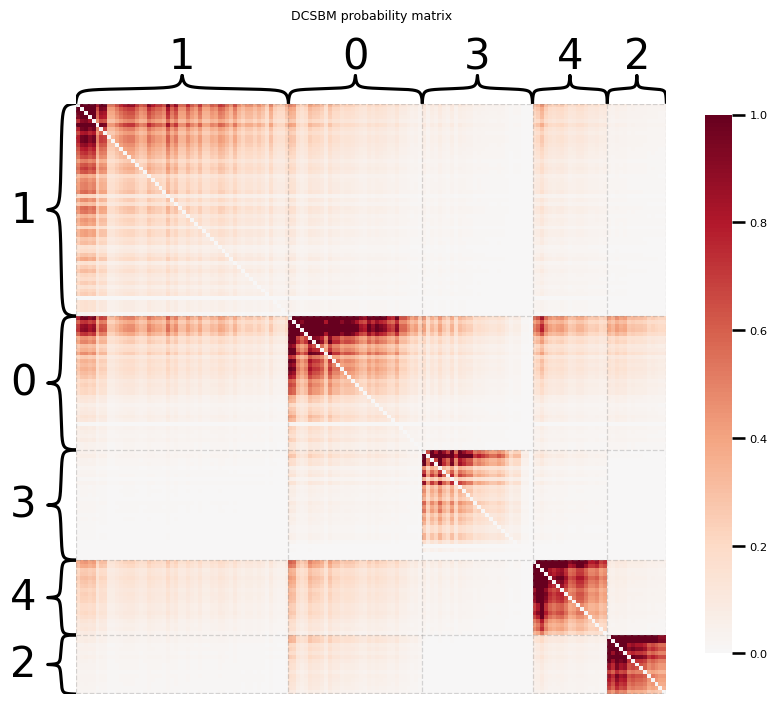

In [6]:
### TRAIN DCSBM MODEL
dcsbme = DCSBMEstimator(directed=True, degree_directed=True, loops=False)
dcsbme.fit(adj, y=None)
print("DCSBM \"B\" matrix:")
print(dcsbme.block_p_)
heatmap(dcsbme.p_mat_,
        inner_hier_labels=dcsbme.vertex_assignments_,
        font_scale=0.5,
        title="DCSBM probability matrix",
        vmin=0,
        vmax=1,
        sort_nodes=True)

<Axes: title={'center': 'Sampled adj probability matrix'}>

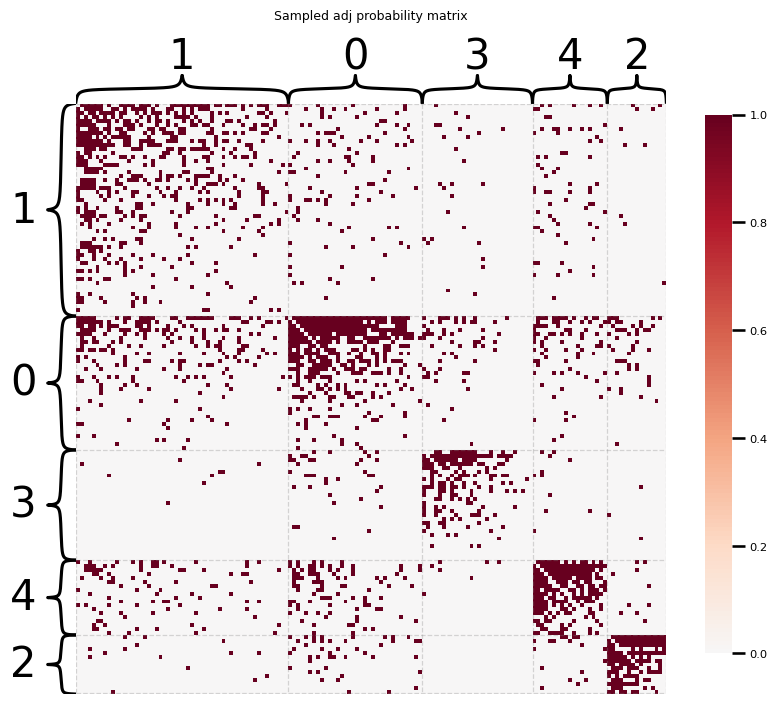

In [7]:
#### SAMPLE MODEL
adj_sampled = dcsbme.sample()
heatmap(adj_sampled[0],
        inner_hier_labels=dcsbme.vertex_assignments_,
        font_scale=0.5,
        title="Sampled adj probability matrix",
        vmin=0,
        vmax=1,
        sort_nodes=True)

In [8]:
### calculate metrics
#conveert adj matrix to edges with default attr values
def adjacency_to_edge_list(adj_matrix, edges):
    edges_sampled = []
    # Iterate over each element in the adjacency matrix
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] != 0:
                # Append a tuple (source, target, weight)
                edges_sampled.append((i, j))
                
    # convert to pandas dataframe
    edges_sampled = pd.DataFrame(edges_sampled, columns=['src', 'dst'] )
    
    #add default values to edge attributes
    edge_cols = [c for c in edges.columns if c not in ('start', 'end')]
    for col in edge_cols:
        edges_sampled[col] = 0.5
    
    return edges_sampled

edges_sampled = adjacency_to_edge_list(adj_sampled[0], edges)

#nodes blijven gelijk
res = compare_metrics2(nodes, edges, nodes, edges_sampled, name='DCSBM')
res


~/Downloads/gtrieScanner_src_01/gtrieScanner -s 3 -m gtrie ~/Downloads/gtrieScanner_src_01/gtries/dir3.gt -d -t html -g temp/edges_adj.csv -o temp/dir3_edges.html 
~/Downloads/gtrieScanner_src_01/gtrieScanner -s 3 -m gtrie ~/Downloads/gtrieScanner_src_01/gtries/dir3.gt -d -t html -g temp/synth_edges_adj.csv -o temp/dir3_synth_edges.html 


,name,value,type,metric,model
0,attr_received_size,0.000000,node_attributes,Wasserstein_distance,DCSBM
1,attr_cnt_to,0.000000,node_attributes,Wasserstein_distance,DCSBM
2,attr_cnt_cc,0.000000,node_attributes,Wasserstein_distance,DCSBM
3,attr_sent_size,0.000000,node_attributes,Wasserstein_distance,DCSBM
4,attr_cnt_send,0.000000,node_attributes,Wasserstein_distance,DCSBM
...,...,...,...,...,...
59,mean_delta_widget,0.051566,widget_count,fraction,DCSBM
60,edge_count,2505.000000,edge_cnt,count,DCSBM
61,orig_edge_count,2689.000000,edge_cnt,count,DCSBM
62,node_count,150.000000,edge_cnt,count,DCSBM


In [35]:
res[res['metric'].str.contains('cluster')]

,name,value,type,metric,model
17,edges,0.421888,cluster_coef,cluster_coefficient,DCSBM
18,synth_edges,0.364661,cluster_coef,cluster_coefficient,DCSBM
19,dif_cluster_coef,0.057227,cluster_coef,cluster_coefficient,DCSBM


In [31]:
node_attributes = res[res['type']=='node_attributes'].groupby(['model', 'name', 'type']).agg({'value': 'mean'}).reset_index()
edge_attributes = res[res['type']=='edge_attributes'].groupby(['model', 'name']).agg({'value': 'mean', 'type': 'max'}).reset_index()
dif_cluster_coef = (res[res['name']=='dif_cluster_coef']
                    .groupby(['model', 'name', 'type'])
                    .agg({'value': 'mean'})
                    # .rename(columns={'name': 'type'})
                    .reset_index()
)
delta_widget = res[res['name']=='mean_delta_widget'].groupby(['model', 'name']).agg({'value': 'mean', 'type': 'max'}).rename(columns={'name': 'type'}).reset_index()

edge_cnt = pd.DataFrame(
    (res[(res['type']=='edge_cnt') & (res['name']=='edge_count')].groupby('model').agg({'value': 'mean'})['value'] -  # synth count
    res[(res['type']=='edge_cnt') & (res['name']=='orig_edge_count')].groupby('model').agg({'value': 'mean'})['value']) /  #orig count
    res[(res['type']=='edge_cnt') & (res['name']=='orig_edge_count')].groupby('model').agg({'value': 'mean'})['value']  # orig count
)
edge_cnt['type'] = "Delta_edge_fraction"
edge_cnt['name'] = "Delta_edge_fraction"
edge_cnt = edge_cnt.reset_index()
# cluster_coef = res[res['name'].str.startswith('dif_')].groupby(['model', 'name']).agg({'value': 'mean', 'type': 'max'}).rename(columns={'name': 'type'}).reset_index()
sum_res = pd.concat([node_attributes, edge_attributes, dif_cluster_coef, edge_cnt, delta_widget], axis=0)

sum_res

,model,name,type,value
0,DCSBM,attr_cnt_cc,node_attributes,0.000000
1,DCSBM,attr_cnt_send,node_attributes,0.000000
2,DCSBM,attr_cnt_to,node_attributes,0.000000
3,DCSBM,attr_received_size,node_attributes,0.000000
4,DCSBM,attr_sent_size,node_attributes,0.000000
5,DCSBM,id,node_attributes,0.000000
6,DCSBM,label,node_attributes,0.000000
0,DCSBM,avg_cc_addressees,edge_attributes,0.347659
1,DCSBM,avg_to_addressees,edge_attributes,0.259222
2,DCSBM,cnt_cc,edge_attributes,0.399693


In [25]:
sum_stat = sum_res.groupby(['model', 'type']).mean('value')
sum_stat = sum_stat.reset_index()
sum_stat = sum_stat.pivot(index='type', columns='model', values='value')
sum_stat


model,DCSBM
type,
Delta_edge_fraction,-0.068427
cluster_coef,0.057227
edge_attributes,0.293875
node_attributes,0.000000
widget_count,0.051566


In [33]:
sum_stat = pd.crosstab(index=sum_res['type'], columns=sum_res['model'], values=sum_res['value'], aggfunc='mean')
sum_stat

model,DCSBM
type,
Delta_edge_fraction,-0.068427
cluster_coef,0.057227
edge_attributes,0.293875
node_attributes,0.000000
widget_count,0.051566


In [46]:
def calculate_model_performance(res):
    """ Calculates the mean per metric over all runs.
    The res dataframe should by the normalized version.
    """
    # node attribute metrics
    node_attributes = (
        res[res['type']=='node_attributes']  # select all metrics related to the node attributes.
        .groupby(['model', 'name', 'type'])  # group by model, metric type and metric name
        .agg({'value': 'mean', 'type': 'max'})  # group by model, metric type and metric name
        .reset_index() 
    )
    
    # edge attribute metric
    edge_attributes = (
        res[res['type']=='edge_attributes']  # select all metrics related to the edge attributes.
        .groupby(['model', 'name', 'type']) # group by model, metric type and metric name
        .agg({'value': 'mean'}) 
        .reset_index()
    )
    
    # difference in clustering coef.
    dif_cluster_coef = (
        res[res['name']=='dif_cluster_coef']  # select all metrics related to the clustering coefficient
        .groupby(['model', 'name', 'type'])  # group by model, metric type and metric name
        .agg({'value': 'mean'})
        .reset_index()
    )
    dif_cluster_coef['type'] = 'dif_cluster_coef'  # set the different in clust coef as separate type to avoid being averages with the cluster coef
    
    # calculate the average fraction difference in widget count.
    delta_widget = (
        res[res['name']=='mean_delta_widget']
        .groupby(['model', 'name', 'type'])
        .agg({'value': 'mean'})
        .reset_index()
    )
    delta_widget['type'] = 'mean_delta_widget'

    # calculate the fraction difference in edge count
    edge_cnt = pd.DataFrame(
        (res[(res['type']=='edge_cnt') & (res['name']=='edge_count')].groupby('model').agg({'value': 'mean'})['value'] -  # synth count
        res[(res['type']=='edge_cnt') & (res['name']=='orig_edge_count')].groupby('model').agg({'value': 'mean'})['value']) /  #orig count
        res[(res['type']=='edge_cnt') & (res['name']=='orig_edge_count')].groupby('model').agg({'value': 'mean'})['value']  # orig count
    )
    edge_cnt['type'] = "Delta_edge_fraction"
    edge_cnt['name'] = "Delta_edge_fraction"
    edge_cnt = edge_cnt.reset_index()
    
    # calculate the synth cluster coef.
    cluster_coef = (
        res[(res['metric']=='cluster_coefficient') & (res['name']=='synth_edges')]
        .groupby(['model', 'name','type'])
        .agg({'value': 'mean'})
        .reset_index()
    )
    sum_res = pd.concat([node_attributes, edge_attributes, dif_cluster_coef, edge_cnt, delta_widget, cluster_coef], axis=0)
    return sum_res
sum_res

,model,name,type,value
0,DCSBM,attr_cnt_cc,node_attributes,0.000000
1,DCSBM,attr_cnt_send,node_attributes,0.000000
2,DCSBM,attr_cnt_to,node_attributes,0.000000
3,DCSBM,attr_received_size,node_attributes,0.000000
4,DCSBM,attr_sent_size,node_attributes,0.000000
5,DCSBM,id,node_attributes,0.000000
6,DCSBM,label,node_attributes,0.000000
0,DCSBM,avg_cc_addressees,edge_attributes,0.347659
1,DCSBM,avg_to_addressees,edge_attributes,0.259222
2,DCSBM,cnt_cc,edge_attributes,0.399693


In [45]:
def calculate_stats(res):
    node_attributes = res[res['type']=='node_attributes'].groupby('model').agg({'value': 'mean', 'type': 'max'}).reset_index()
    edge_attributes = res[res['type']=='edge_attributes'].groupby('model').agg({'value': 'mean', 'type': 'max'}).reset_index()
    dif_cluster_coef = res[res['name']=='dif_cluster_coef'].groupby('model').agg({'value': 'mean', 'type': 'max'}).rename(columns={'name': 'type'})
    delta_widget = res[res['name']=='mean_delta_widget'].groupby('model').agg({'value': 'mean', 'type': 'max'}).rename(columns={'name': 'type'})
    edge_cnt = (res[(res['type']=='edge_cnt') & (res['name']=='edge_count')].groupby('model').agg({'value': 'mean'})['value'] -
        res[(res['type']=='edge_cnt') & (res['name']=='orig_edge_count')].groupby('model').agg({'value': 'mean'})['value']
    )
    edge_cnt['type'] = "Delta_edge_count"
    cluster_coef = res[res['name'].str.startswith('dif_')][['name', 'value'] ].rename(columns={'name': 'type'})
    sum_res = pd.concat([node_attributes, edge_attributes, dif_cluster_coef, delta_widget, edge_cnt, cluster_coef], axis=0)
    sum_stat = sum_res.groupby('type').mean()
    return sum_stat 

In [46]:
calculate_stats(res)

TypeError: agg function failed [how->mean,dtype->object]

In [6]:
adj, labels = load_drosophila_right(return_labels=True)
adj = binarize(adj)
adj.shape

(213, 213)

In [16]:
labels

array(['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P

DCSBM "B" matrix:
[[173.   0.  24.   8.  60.  28.]
 [  1.   7. 193.  48.   0. 198.]
 [746.   2. 719.  61. 442. 618.]
 [ 33.  11.  43. 169.   9. 164.]
 [ 63.   0. 403.   7.   0. 353.]
 [724.   6. 523. 283. 443. 974.]]


<Axes: title={'center': 'DCSBM probability matrix'}>

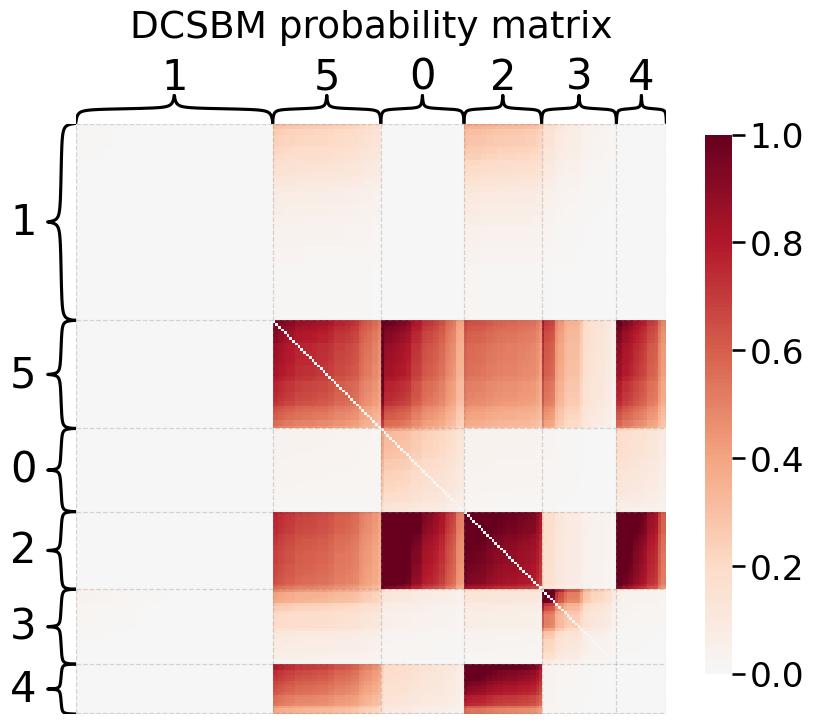

In [21]:

dcsbme = DCSBMEstimator(directed=True,loops=False)
dcsbme.fit(adj, y=None)
print("DCSBM \"B\" matrix:")
print(dcsbme.block_p_)
heatmap(dcsbme.p_mat_,
        inner_hier_labels=dcsbme.vertex_assignments_,
        font_scale=1.5,
        title="DCSBM probability matrix",
        vmin=0,
        vmax=1,
        sort_nodes=True)


<Axes: title={'center': 'DCSBM probability matrix'}>

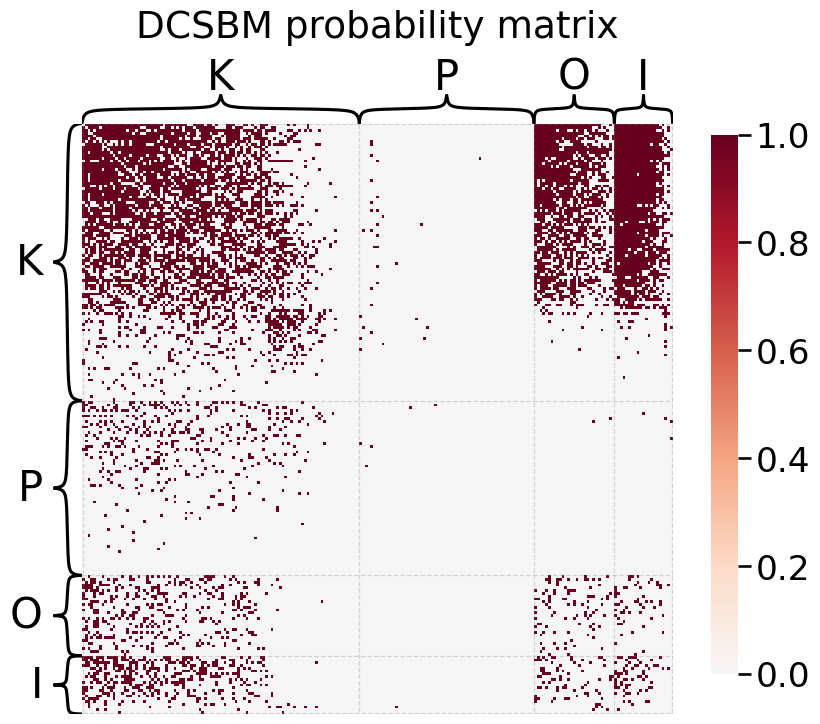

In [18]:
test = dcsbme.sample()
heatmap(test[0],
        inner_hier_labels=labels,
        font_scale=1.5,
        title="DCSBM probability matrix",
        vmin=0,
        vmax=1,
        sort_nodes=True)